In [1]:
# https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/latest/hand_landmarker.task
import mediapipe as mp
import numpy as np
from mediapipe.framework.formats import landmark_pb2
import cv2

In [2]:
BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

model_path = 'hand_landmarker.task'

# options for landmarker in image mode:
options = mp.tasks.vision.HandLandmarkerOptions(
    base_options=mp.tasks.BaseOptions(model_asset_path=model_path),
    running_mode=mp.tasks.vision.RunningMode.IMAGE,
    min_hand_detection_confidence = 0.2,
    min_hand_presence_confidence = 0.2,
    min_tracking_confidence = 0.2,
    # num_hands=2
)

def close(landmarker):
  landmarker.close()

In [3]:
# Only for livestream results
def get_result(result: mp.tasks.vision.HandLandmarkerResult, output_image: mp.Image, timestamp_ms: int):
    return result
    # print(f'hand landmarker result: {result}') 



In [4]:
def draw_landmarks_on_image(rgb_image, detection_result: mp.tasks.vision.HandLandmarkerResult):
    """Courtesy of https://github.com/googlesamples/mediapipe/blob/main/examples/hand_landmarker/python/hand_landmarker.ipynb"""
    global first
    try:
        if detection_result.hand_landmarks == []:
            return rgb_image
        else:
            hand_landmarks_list = detection_result.hand_landmarks
            annotated_image = np.copy(rgb_image)
            
            # Loop through the detected hands to visualize.
            for idx in range(len(hand_landmarks_list)):
                print(hand_landmarks_list[idx])
                hand_landmarks = hand_landmarks_list[idx]
                # Draw the hand landmarks.
                hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
                hand_landmarks_proto.landmark.extend([
                    landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks])
                mp.solutions.drawing_utils.draw_landmarks(
                    annotated_image,
                    hand_landmarks_proto,
                    mp.solutions.hands.HAND_CONNECTIONS,
                    mp.solutions.drawing_styles.get_default_hand_landmarks_style(),
                    mp.solutions.drawing_styles.get_default_hand_connections_style())
                
            return annotated_image
    except Exception as e:
        print(e, 'exception')
        return rgb_image

In [5]:
def detect(image, clazz, landmarker):
    return (landmarker.detect(image=image), clazz)

In [6]:
# load the landmarker
landmarker = mp.tasks.vision.HandLandmarker.create_from_options(options)

# load image
image = mp.Image.create_from_file('./../data/American Sign Language Letters.v1-v1.tensorflow/train/M18_jpg.rf.129826d37d00c7e46376752d8649edaa.jpg')

# detect result to draw detected keypoints on frame
detection_result = detect(image, 'A', landmarker)
image_with_landmarks = draw_landmarks_on_image(image.numpy_view(), detection_result[0])

# show frame with keypoints drawn
cv2.imshow('Image', image_with_landmarks)

# stop!
#cv2.waitKey(0)
        
close(landmarker)
cv2.destroyAllWindows()

[NormalizedLandmark(x=0.4512444734573364, y=0.6170030236244202, z=-9.343098383851611e-08, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.48954522609710693, y=0.5841641426086426, z=-0.02537645399570465, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4955238997936249, y=0.5283651947975159, z=-0.044034961611032486, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.44175049662590027, y=0.500369668006897, z=-0.06216815486550331, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.3925633132457733, y=0.48377835750579834, z=-0.07727379351854324, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4785412847995758, y=0.46633273363113403, z=-0.026574909687042236, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.4938644468784332, y=0.424955278635025, z=-0.06438133120536804, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5115581154823303, y=0.4621637463569641, z=-0.0878673866391182, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5188916325569153, y=0.50019

I0000 00:00:1761485534.715860 9858110 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1761485534.750309 9859955 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761485534.763550 9859959 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761485534.792594 9859954 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


In [7]:
def get_keypoints(landmarker, base_path, file_name, clazz):
    image = mp.Image.create_from_file(base_path + file_name)
    return detect(image, clazz, landmarker)

In [8]:
def create_coord_list(detected_landmarks):
  coord_list = []
  for i in detected_landmarks:
    coord_list.append([i.x, i.y, i.z])
  return coord_list
    
def orthonormal_basis_from_triangle(p1, p2, p3):
    """Return orthonormal triad (e1,e2,e3): e1 along (p2-p1), e2 in the plane, e3 = normal."""
    u = p2 - p1
    v = p3 - p1
    n = np.cross(u, v)
    if np.linalg.norm(n) < 1e-12:
        raise ValueError("Anchor points are collinear; cannot define a plane.")
    e1 = u / np.linalg.norm(u)
    v_perp = v - np.dot(v, e1) * e1
    e2 = v_perp / np.linalg.norm(v_perp)
    e3 = np.cross(e1, e2)  # already unit
    return e1, e2, e3

def solve_affine2d(src_xy, dst_xy):
    """Solve 2D affine mapping (x,y)->(X,Y) from 3 point pairs. Returns 2x2 M and 2-dim t."""
    A, b = [], []
    for (x, y), (X, Y) in zip(src_xy, dst_xy):
        A.append([x, y, 1, 0, 0, 0])
        A.append([0, 0, 0, x, y, 1])
        b += [X, Y]
    A = np.asarray(A, float)
    b = np.asarray(b, float)
    m11, m12, tx, m21, m22, ty = np.linalg.solve(A, b)
    M = np.array([[m11, m12],
                  [m21, m22]], float)
    t = np.array([tx, ty], float)
    return M, t

def tilt_from_z_original(P, idx0=0, idx1=17, degrees=False):
    """
    Angle between the original vector P[idx1]-P[idx0] and the global z-axis.
    Returns angle in radians
    """
    v = np.asarray(P[idx1]) - np.asarray(P[idx0])
    n = np.linalg.norm(v)
    if n < 1e-12:
        return np.nan  # or raise ValueError("Zero-length vector")
    v_unit = v / n
    cos_theta = np.clip(v_unit[2], -1.0, 1.0)   # dot(v̂, ẑ) = z-component
    theta = np.arccos(cos_theta)                # 0 = vertical, pi/2 = horizontal
    return theta

def normalize_landmarks(points, anchor_idx=(0,5,17), lambda_normal=1.0):
    """
    Build a 3D affine transform (A,t) so that:
      P[i1] -> (0,0,0), P[i2] -> (0,1,0), P[i3] -> (1,1,0),
    and the plane normal maps to the Z axis with scale lambda_normal.
    Returns transformed points (N,3) and (A,t).
    """
    P = np.asarray(points, float)
    i1, i2, i3 = anchor_idx
    p1, p2, p3 = P[i1], P[i2], P[i3]

    # Local orthonormal basis B = [e1 e2 e3]
    e1, e2, e3 = orthonormal_basis_from_triangle(p1, p2, p3)
    B = np.column_stack([e1, e2, e3])          # world <- local
    BT = B.T                                    # local <- world

    # Local coordinates of anchors (q = BT * (p - p1))
    q1 = BT @ (p1 - p1)                         # ~ (0,0,0)
    q2 = BT @ (p2 - p1)                         # (x2, y2, 0)
    q3 = BT @ (p3 - p1)                         # (x3, y3, 0)

    src_xy = np.vstack([q1[:2], q2[:2], q3[:2]])
    dst_xy = np.array([[0.,0.],[0.,1.],[1.,1.]], float)

    # Exact 2D affine that hits the three targets in XY
    M2, t2 = solve_affine2d(src_xy, dst_xy)

    # Compose full 3x3 local linear map: XY via M2, Z via lambda_normal
    L_local = np.array([[M2[0,0], M2[0,1], 0.0],
                        [M2[1,0], M2[1,1], 0.0],
                        [0.0,      0.0,    lambda_normal]], float)

    # Because q1 = (0,0,0) maps to (0,0,0), t2 should be ~0; keep it for completeness
    t_local = np.array([t2[0], t2[1], 0.0], float)

    # Convert to a single world-space affine: P' = A @ P + t
    # q = BT @ (P - p1);  q' = L_local @ q + t_local;  P' = q'  (targets are in world axes)
    A = L_local @ BT
    t = -L_local @ (BT @ p1) + t_local

    # Apply to all points
    normalized_points = (A @ P.T).T + t

    return normalized_points, tilt_from_z_original(points)

In [9]:
def store_result(result, clazz, normalize = False):
    d = {}
    if normalize:
        coords = create_coord_list(result.hand_landmarks[0])
        norm_coords, tilt = normalize_landmarks(coords)
        for k in range(len(coords)):
            d[str(k)+'_x'] = norm_coords[k][0]
            d[str(k)+'_y'] = norm_coords[k][1]
            d[str(k)+'_z'] = norm_coords[k][2]
        d['tilt'] = tilt
    
    else:
        for k,v in enumerate(result.hand_landmarks[0]):
            d[str(k)+'_x'] = v.x
            d[str(k)+'_y'] = v.y
            d[str(k)+'_z'] = v.z
        
    d['clazz'] = clazz
    # print(d)
    return d
    
    # store result values in dict and add to list

In [10]:
# convert list of dicts to pd.df
def get_data_frame(result_list):
    return pd.DataFrame(result_list)

In [11]:
#!pip install pandas==2.1.4 moet numpy <2 gebruiken voor mediapipe!
import pandas as pd

# create the landmarker
landmarker = mp.tasks.vision.HandLandmarker.create_from_options(options)

data_path = './../data/American Sign Language Letters.v1-v1.tensorflow/'

train_data = pd.read_csv(data_path + 'train/_annotations.csv')
train_data.head()

valid_data = pd.read_csv(data_path + 'valid/_annotations.csv')
valid_data.head()

test_data = pd.read_csv(data_path + 'test/_annotations.csv')
test_data.head()

train_data[:1]
counter = 0

def store_data(data, folder, normalize=False):
    result_list = []
    # loop through images in csv and get results
    for i in range(len(data)):
        values = data[i:i+1][['filename','class']].values[0]
        file_name, clazz = values[0], values[1]
        result = get_keypoints(landmarker, data_path + folder, file_name, clazz)
        if len(result[0].hand_landmarks) > 0:
            result_list.append(store_result(result[0], clazz, normalize))
    return result_list


I0000 00:00:1761485535.314584 9858110 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M2
W0000 00:00:1761485535.320492 9860026 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761485535.325721 9860028 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [12]:
# Load results into DataFrame
df_train = get_data_frame(store_data(train_data, 'train/'))
df_train.head()

df_valid = get_data_frame(store_data(valid_data, 'valid/'))
df_valid.head()

df_test = get_data_frame(store_data(test_data, 'test/'))
df_test.head()

,0_x,0_y,0_z,1_x,1_y,1_z,2_x,2_y,2_z,3_x,...,18_x,18_y,18_z,19_x,19_y,19_z,20_x,20_y,20_z,clazz
0,0.220415,0.407690,-2.440547e-07,0.244301,0.368207,-0.045711,0.274913,0.339825,-0.079548,0.289751,...,0.336819,0.531857,-0.084896,0.344716,0.555066,-0.090271,0.361922,0.579919,-0.086737,J
1,0.172257,0.550705,1.030512e-06,0.338432,0.565231,0.000291,0.450155,0.578939,-0.082046,0.520086,...,0.331131,0.584223,-0.407599,0.324186,0.609010,-0.361778,0.292037,0.568101,-0.332368,Q
2,0.334459,0.794282,-8.153771e-07,0.412889,0.802863,-0.086060,0.446114,0.792671,-0.147088,0.377032,...,0.157035,0.766295,-0.166359,0.190985,0.804903,-0.147521,0.211286,0.783851,-0.133051,Z
3,0.778663,0.938040,-2.469441e-07,0.633434,1.000040,-0.181509,0.485259,0.941501,-0.275909,0.400036,...,0.580504,0.472399,-0.169614,0.501468,0.439170,-0.191708,0.443163,0.417601,-0.202619,R
4,0.438959,0.679662,-1.536524e-07,0.502395,0.674172,-0.038524,0.556396,0.663928,-0.070050,0.545204,...,0.365489,0.710150,-0.108938,0.375235,0.713022,-0.104147,0.370458,0.694007,-0.102026,Z


In [13]:
# print(df_train.info())
# print(df_valid.info())
# print(df_test.info())

<class 'pandas.core.series.Series'>
RangeIndex: 1298 entries, 0 to 1297
Series name: clazz
Non-Null Count  Dtype 
--------------  ----- 
1298 non-null   object
dtypes: object(1)
memory usage: 10.3+ KB
None
['U' 'K' 'W' ... 'A' 'W' 'S']
(1298, 2)
[ 9 11  1 ...  7 20 14]




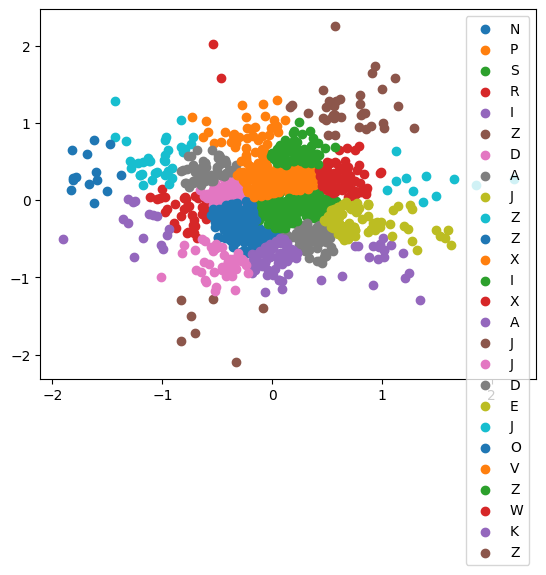

In [14]:
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from statistics import mode

# training features
X_features = ['0_x','0_y','0_z','1_x','1_y','1_z','2_x','2_y','2_z'
                    ,'3_x','3_y','3_z','4_x','4_y','4_z','5_x','5_y','5_z'
                    ,'6_x','6_y','6_z','7_x','7_y','7_z','8_x','8_y','8_z'
                    ,'9_x','9_y','9_z','10_x','10_y','10_z','11_x','11_y','11_z'
                    ,'12_x','12_y','12_z','13_x','13_y','13_z','14_x','14_y','14_z'
                    ,'15_x','15_y','15_z','16_x','16_y','16_z','17_x','17_y','17_z'
                    ,'18_x','18_y','18_z','19_x','19_y','19_z','20_x','20_y','20_z'
]

if 'tilt' not in df_train.columns and 'tilt' in X_features:
    X_features.remove('tilt')

y_target = 'clazz'

# split into data and targets
df_training_x = df_train[X_features]
df_valid_x = df_valid[X_features]
df_test_x = df_test[X_features]

df_training_y = df_train[y_target]
df_valid_y = df_valid[y_target]
df_test_y = df_test[y_target]

# print information for DataFrame
print(df_training_y.info())
print(df_training_y.values)

# reduce dimensions for plotting and plot 26 clusters
pca = PCA(2)
x = pca.fit_transform(df_training_x.values)
print(x.shape)
kmeans = KMeans(n_clusters=26, random_state=42).fit(x) #for 2 Clusters
print(kmeans.labels_)
print()
print()

#Getting unique labels
unique_labels = np.unique(kmeans.labels_)

# plotting results: 
for i in unique_labels:
    indices = np.where(kmeans.labels_ == i)[0]
    cluster_labels = df_training_y[indices]
    most_common_prediction = mode(cluster_labels.values)
    plt.scatter(x[kmeans.labels_ == i , 0] , x[kmeans.labels_ == i , 1] , label = most_common_prediction)
plt.legend()
plt.show()


In [15]:
# Logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

def train_logistic_regression(X_train, y_train):
    return LogisticRegression(max_iter=500, tol=1e-12).fit(X_train.values, y_train.values)

def test_logistic_regression(model, title, X, y):
    print(f'Statistics: {title}')
    print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y, y_pred=model.predict(X=X.values))))
    print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y, y_pred=model.predict(X=X.values))))
    print(classification_report(y_true=y, y_pred=model.predict(X=X.values)))
    print()

lr_model = train_logistic_regression(df_training_x, df_training_y)
print('model fit in {} iterations'.format(lr_model.n_iter_[0]))
print()
test_logistic_regression(lr_model, 'Training', df_training_x, df_training_y)
test_logistic_regression(lr_model, 'Validation', df_valid_x, df_valid_y)
test_logistic_regression(lr_model, 'Test', df_test_x, df_test_y)


model fit in 296 iterations

Statistics: Training
accuracy: 0.6649
f1: 0.6565
              precision    recall  f1-score   support

           A       0.41      0.75      0.53        64
           B       0.79      0.77      0.78        35
           C       0.79      0.45      0.58        33
           D       0.76      0.56      0.64        50
           E       0.83      0.75      0.78        51
           F       0.80      0.98      0.88        53
           G       0.60      0.90      0.72        49
           H       1.00      0.39      0.56        36
           I       0.74      0.90      0.81        71
           J       0.47      0.63      0.54        71
           K       0.72      0.84      0.78        45
           L       0.64      0.69      0.66        64
           M       0.68      0.33      0.45        45
           N       0.70      0.57      0.62        53
           O       0.69      0.47      0.56        47
           P       0.73      0.56      0.64        39
   

/opt/anaconda3/envs/mp312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/mp312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/mp312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anacond

In [16]:
# Load normalized results into DataFrame
df_train_normalized = get_data_frame(store_data(train_data, 'train/', True))
df_train_normalized.head()

df_valid_normalized = get_data_frame(store_data(valid_data, 'valid/', True))
df_valid_normalized.head()

df_test_normalized = get_data_frame(store_data(test_data, 'test/', True))
df_test_normalized.head()

,0_x,0_y,0_z,1_x,1_y,1_z,2_x,2_y,2_z,3_x,...,18_y,18_z,19_x,19_y,19_z,20_x,20_y,20_z,tilt,clazz
0,0.000000e+00,0.000000e+00,0.0,-0.236365,0.090714,-0.045320,-0.397412,0.228750,-0.075158,-0.165666,...,1.275380,-0.019064,1.603989,1.415565,-0.016590,1.828242,1.588912,-0.002883,1.935038,J
1,-4.163336e-17,2.775558e-17,0.0,-0.318874,0.206240,0.071910,-0.285243,0.543234,0.132616,-0.133700,...,1.177248,0.129970,0.807489,1.037176,0.145759,0.766014,0.954810,0.093304,2.952527,Q
2,0.000000e+00,4.440892e-16,0.0,-0.228761,0.216037,0.078402,-0.281894,0.448145,0.118872,0.096581,...,0.901984,0.066194,0.873906,0.663000,0.085910,0.768739,0.661153,0.064425,2.187872,Z
3,-4.440892e-16,0.000000e+00,0.0,-0.549484,0.348232,0.091353,-0.526466,0.783675,0.194950,-0.171926,...,1.469241,0.072218,1.360619,1.651892,0.135655,1.411719,1.770269,0.184471,1.861885,R
4,0.000000e+00,-8.881784e-16,0.0,-0.256617,0.129983,0.047083,-0.479880,0.262565,0.082812,-0.313566,...,0.670651,0.064559,0.743180,0.604485,0.066871,0.763330,0.703402,0.051672,2.247725,Z


In [17]:
if 'tilt' in df_train_normalized.columns and not 'tilt' in X_features:
    X_features.append('tilt')

# prepare data for training
df_training_normalized_x = df_train_normalized[X_features]
df_valid_normalized_x = df_valid_normalized[X_features]
df_test_normalized_x = df_test_normalized[X_features]

df_training_normalized_y = df_train_normalized[y_target]
df_valid_normalized_y = df_valid_normalized[y_target]
df_test_normalized_y = df_test_normalized[y_target]

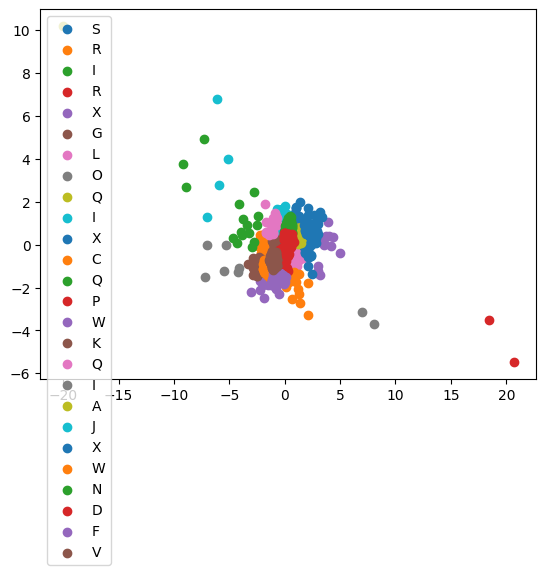

In [18]:
# test cluster on normalized training data
x_normalized = pca.fit_transform(df_training_normalized_x.values)
kmeans_normalized = KMeans(n_clusters=26, random_state=42).fit(x_normalized) # for 26 Clusters

#Getting unique labels
unique_labels_normalized = np.unique(kmeans_normalized.labels_)

# plotting results: 
for i in unique_labels_normalized:
    indices = np.where(kmeans_normalized.labels_ == i)[0]
    cluster_labels_normalized = df_training_normalized_y[indices]
    most_common_prediction_normalized = mode(cluster_labels_normalized.values)
    plt.scatter(x_normalized[kmeans_normalized.labels_ == i , 0] , x_normalized[kmeans_normalized.labels_ == i , 1] , label = most_common_prediction_normalized)
plt.legend()
plt.show()

In [19]:
df_training_normalized_x['tilt'].describe()
#df_train_normalized.groupby('clazz').mean()

count    1298.000000
mean        1.802516
std         0.313622
min         0.540695
25%         1.681113
50%         1.829441
75%         1.949540
max         3.042798
Name: tilt, dtype: float64

In [20]:
# test log reg model on normalized data and compare results
lr_model = train_logistic_regression(df_training_normalized_x, df_training_normalized_y)
print('model fit in {} iterations'.format(lr_model.n_iter_[0]))
test_logistic_regression(lr_model, 'Training', df_training_normalized_x, df_training_normalized_y)
test_logistic_regression(lr_model, 'Validation', df_valid_normalized_x, df_valid_normalized_y)
test_logistic_regression(lr_model, 'Test', df_test_normalized_x, df_test_normalized_y)

# TODO look at ConvergenceWarning

model fit in 500 iterations
Statistics: Training
accuracy: 0.8590
f1: 0.8580
              precision    recall  f1-score   support

           A       0.69      0.89      0.78        64
           B       0.88      1.00      0.93        35
           C       0.80      0.85      0.82        33
           D       0.80      0.82      0.81        50
           E       0.89      0.94      0.91        51
           F       1.00      0.98      0.99        53
           G       0.87      0.94      0.90        49
           H       0.92      0.94      0.93        36
           I       0.88      0.92      0.90        71
           J       0.84      0.58      0.68        71
           K       0.98      0.89      0.93        45
           L       0.89      0.92      0.91        64
           M       0.93      0.82      0.87        45
           N       0.88      0.83      0.85        53
           O       0.73      0.85      0.78        47
           P       0.72      0.79      0.76        39
    

/opt/anaconda3/envs/mp312/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
# test random forest model
from sklearn.ensemble import RandomForestClassifier

# TODO hypertune parameters...
def train_rf_model(X_train, y_train):
    hyperparameters = {
        'n_jobs': -1,
        'criterion': 'log_loss', # {'gini', 'log_loss', 'entropy'}
        'max_depth': 20, # max 26 letters?
        'max_features': 'sqrt', # {'sqrt', 'log2', None }
        'n_estimators': 100, # 10 - 100 (standard=100)
        'random_state': 42,
        'min_samples_leaf': 10, # experiment with values 10 - 50?
        'min_samples_split': 15 # experiment with values 5-20?
        # max_leaf_nodes
        # min_impurity_decrease
        # min_weight_fraction_leaf
    }
    model = RandomForestClassifier(**hyperparameters)
    model.fit(X_train, y_train)
    return model

def test_rf_model(model, title, X, y):
    # y_pred = model.predict_proba(X_test)[:,1]
    print(f'Statistics: {title}')
    print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y, y_pred=model.predict(X=X))))
    print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y, y_pred=model.predict(X=X))))
    print(classification_report(y_true=y, y_pred=model.predict(X=X)))
    

rf_model = train_rf_model(df_training_normalized_x, df_training_normalized_y)
test_rf_model(rf_model, 'Training', df_training_normalized_x, df_training_normalized_y)
test_rf_model(rf_model, 'Validation', df_valid_normalized_x, df_valid_normalized_y)
test_rf_model(rf_model, 'Test', df_test_normalized_x, df_test_normalized_y)

Statistics: Training
accuracy: 0.8860
f1: 0.8877
              precision    recall  f1-score   support

           A       0.79      0.91      0.85        64
           B       0.92      0.94      0.93        35
           C       0.62      0.97      0.75        33
           D       0.79      0.88      0.83        50
           E       0.94      0.90      0.92        51
           F       1.00      0.98      0.99        53
           G       0.86      0.90      0.88        49
           H       0.92      0.94      0.93        36
           I       0.98      0.86      0.92        71
           J       0.83      0.85      0.84        71
           K       0.95      0.91      0.93        45
           L       0.97      0.92      0.94        64
           M       0.93      0.84      0.88        45
           N       0.92      0.87      0.89        53
           O       0.78      0.91      0.84        47
           P       0.84      0.82      0.83        39
           Q       0.75      0.8

/opt/anaconda3/envs/mp312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/mp312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/mp312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt

In [22]:
# TODO train neural network
from sklearn.neural_network import MLPClassifier

def train_nn_model(X_train, y_train):
    clf = MLPClassifier(
        solver='adam', 
        alpha=1e-5,
        hidden_layer_sizes=(26, 26), 
        random_state=42,
        max_iter=500
    )
    clf.fit(X_train, y_train)
    return clf

def test_nn_model(model, title, X, y):
    # y_pred = model.predict_proba(X_test)[:,1]
    print(f'Statistics: {title}')
    print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y, y_pred=model.predict(X=X))))
    print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y, y_pred=model.predict(X=X))))
    print(classification_report(y_true=y, y_pred=model.predict(X=X)))

nn_model = train_nn_model(df_training_normalized_x, df_training_normalized_y)
test_nn_model(nn_model, 'Training', df_training_normalized_x, df_training_normalized_y)
test_nn_model(nn_model, 'Validation', df_valid_normalized_x, df_valid_normalized_y)
test_nn_model(nn_model, 'Test', df_test_normalized_x, df_test_normalized_y)

Statistics: Training
accuracy: 0.9245
f1: 0.9247
              precision    recall  f1-score   support

           A       0.86      0.92      0.89        64
           B       1.00      1.00      1.00        35
           C       0.91      0.91      0.91        33
           D       0.83      0.90      0.87        50
           E       0.98      0.88      0.93        51
           F       1.00      0.98      0.99        53
           G       0.89      0.98      0.93        49
           H       0.92      0.97      0.95        36
           I       1.00      0.97      0.99        71
           J       0.87      0.83      0.85        71
           K       1.00      0.91      0.95        45
           L       0.95      0.92      0.94        64
           M       0.90      0.96      0.92        45
           N       0.96      0.89      0.92        53
           O       0.88      0.96      0.92        47
           P       0.85      0.87      0.86        39
           Q       0.87      0.8

/opt/anaconda3/envs/mp312/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/mp312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/mp312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/mp312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: Unde

In [23]:
# TODO refine clusters Try TSNE? https://www.kaggle.com/code/mikedelong/f1-1-with-logistic-regression

In [89]:
import re
import itertools
import nltk
#from nltk.corpus import brown
from wordfreq import word_frequency
import heapq
import time

#nltk.download('brown')
#DATA_BROWN_TOKENIZED = brown.words()
#BROWN_VOCAB = set(re.sub(r'[^A-Z]', '', word.upper()) for word in DATA_BROWN_TOKENIZED)

In [90]:
def get_random_landmarks_for_word(word, classified_landmarks):
    word = re.sub(r'[^A-Z]', '', word.upper())
    landmarks = pd.DataFrame()
    for char in word:
        char_landmark = classified_landmarks[classified_landmarks["clazz"] == char].sample(n=1).drop(columns=["clazz"])
        landmarks = pd.concat([landmarks, char_landmark], ignore_index=True)
    return landmarks

def probabilities_letter(landmark_x, model):
    prob_dict = {}
    probs = model.predict_proba(landmark_x)
    for cls, p in zip(model.classes_, probs[0]):
        #print(f"{cls}: {p:.3f}")
        prob_dict[cls] = p
    return prob_dict

def is_misspelled(word, lan):
    return not word_frequency(word, lan) > 0

def find_top_options(word_landmarks, model, num_options = 5, max_misspell = 2, include_vocab_freq = True, language = 'en', timeout = 5):
    top_letters = []
    log_probs_landmarks = []
    log_probs_diff = []

    #find all possible values for the landmarks including the probabilities
    for i in range(len(word_landmarks)):
        landmark = word_landmarks.iloc[[i]]
        #print(landmark)
        probs = probabilities_letter(landmark, model)
        top_letters_landmark = dict(sorted(probs.items(), key=lambda x: x[1], reverse=True))#[:num_options]) #we need max num_options possibilities per letter
        top_letter_landmark = sorted(probs, key=probs.get, reverse=True)[0]
        #print(top_letter_landmark)
        log_probs_diff.append([])
        #print(log_probs_diff)
        for letter in top_letters_landmark:
            if probs[letter] == 0:
                top_letters_landmark.remove(letter)
            else:
                log_probs_diff[i].append((letter, np.log(top_letters_landmark[letter]) - np.log(top_letters_landmark[top_letter_landmark]))) 

    
    #find all possible words in descending order of likeliness
    # initial state: pick the best (0) from each list
    start_indices = tuple([0]*len(log_probs_diff))
    start_choice = [log_probs_diff[i][0] for i in range(len(log_probs_diff))]
    start_sum = sum(val for _, val in start_choice)

    start_word = ''.join(char for char, _ in tuple(log_probs_diff[i][0] for i in range(len(log_probs_diff))) )   

    # max-heap (negate sums because heapq is min-heap)
    heap = [(-start_sum, start_indices)]
    seen = {start_indices}

    results = []
    start_time = time.time()
    run_time = 0
    while heap and len(results) < num_options and run_time <= timeout:
        
        #print(new_time - start_time)
        neg_sum, idx_tuple = heapq.heappop(heap)
        current_sum = -neg_sum
        # build the actual combo
        combo = tuple(log_probs_diff[i][idx_tuple[i]] for i in range(len(log_probs_diff)))
        
        word = ''.join(char for char, _ in combo)
        num_misspell = sum(1 for _, num in combo if num != 0)
        
        if not is_misspelled(word, language) and num_misspell <= max_misspell:
            #print(word, "has been found with", num_misspell, "differences.")
            word_prob = np.exp(current_sum) * word_frequency(word, language)
            results.append((word, word_prob))

        # push neighbors: increment one dimension (if possible)
        for dim in range(len(log_probs_diff)):
            j = idx_tuple[dim]
            if j + 1 < len(log_probs_diff[dim]):
                nxt = list(idx_tuple)
                nxt[dim] = j + 1
                nxt = tuple(nxt)
                if nxt not in seen:
                    # compute new sum efficiently
                    old_letter, old_val = log_probs_diff[dim][j]
                    new_letter, new_val = log_probs_diff[dim][j+1]
                    heapq.heappush(heap, (-(current_sum - old_val + new_val), nxt))
                    seen.add(nxt)
        new_time = time.time()
        run_time = new_time - start_time
    if run_time > timeout:
        print("Time limit of {} seconds reached.".format(timeout), "{} word(s) found".format(len(results)), "for original {}.".format(start_word))

    return start_word, sorted(results, key=lambda x: x[1], reverse=True)


In [95]:
word = 'testing'
test_set = get_random_landmarks_for_word(word, df_train_normalized)

#Currently still tries num_options ** len(word) words, so can get very slow very easily for longer words. 
start_word, improved_words = find_top_options(test_set, nn_model, num_options = 10, max_misspell = 5, language = 'en', timeout = 10)
print("Original interpretation:", start_word)
for alternative_word, probability in improved_words:
    print(alternative_word, "has probability {:.10f}".format(probability))


test_sentence = "There is a chance we might not see each other again."
interpreted_sentence = ""
improved_sentence = ""
for word in test_sentence.split():
    lms = get_random_landmarks_for_word(word, df_train_normalized)
    start_word, improved_words = find_top_options(lms, nn_model, num_options = 10, max_misspell = 5, language = 'en', timeout = 10)
    interpreted_sentence += " " + start_word
    if len(improved_words) > 0:
        improved_sentence += " " + improved_words[0][0]
    else:
        improved_sentence += " " + start_word

print("Test sentence:", test_sentence)
print("Interpreted sentence:", interpreted_sentence)
print("Improved sentence:", improved_sentence)


Original interpretation: TESTING
TESTING has probability 0.0000468000
NESTING has probability 0.0000002529
MEETING has probability 0.0000000264
TEXTING has probability 0.0000000183
TASTING has probability 0.0000000098
MESSING has probability 0.0000000010
TENTING has probability 0.0000000010
TOSSING has probability 0.0000000005
NETTING has probability 0.0000000004
JESTING has probability 0.0000000001
Test sentence: There is a chance we might not see each other again.
Interpreted sentence:  THERE IS A CHANCE WE MIGHT NOT SEE EACH OTHER OGAIN
Improved sentence:  THERE IS A CHANCE WE MIGHT NOT SEE EACH OTHER AGAIN
